In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 cd /content/drive/Mydrive/LG_AI_2021/LG-Vision-Academy/basic_DL/Day2/answer

In [ ]:
# for data analysis
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

import torch

# CNN Introduction with MNIST dataset

본 자료는 CNN 모델에 대한 이해를 돕기 위해 제작된 사전 자료입니다.   
본 학습 전에 `Pytorch` 패키지를 활용해 학습 데이터 구성과 컨볼루션 신경망 학습을 어떻게 하는지 알아보려고 합니다.    
특히, MNIST 손글씨 데이터셋을 활용해 신경망 학습을 공부해보겠습니다.

본 자료는 아래 분들의 자료를 참고하여 만들었습니다.   
Copyright @ cb_park@korea.ac.kr (Cheonbok Park), joonleesky@kaist.ac.kr (Hojoon Lee)

## 성능 평가를 위한 Confusion Matrix(오차행렬)

![image.png](attachment:0da9da30-8188-453d-bc6a-2d8f86a2f046.png)

먼저 표 내부에 있는 단어들에 대한 설명을 드리겠습니다.   
설명의 편의성을 위해서 환자다(Positive) / 환자가 아니다(Negative) 로 설명드리겠습니다.

- Actual(Positive) : 실제 환자   
- Actual(Negative) : 실제 환자가 아님   
- Predict(Positive) : 실제 환자로 예측   
- Predict(Negative) : 환자가 아닌 것으로 예측   

이번엔 각각의 교차된 지표에 대해서 설명드리겠습니다. 이 부분은 앞의 단어를 **예측에 대한 성공/실패**, 뒤의 단어를 **긍정예측/부정예측** 이라고 생각하시면 생각하시기 쉬울겁니다!

- TP(True Positive) : 긍정예측을 성공 즉, 환자라고 예측해서 실제 환자임을 맞춤   
- TN(True Negative) : 부정예측을 성공 즉, 비환자라고 예측하여 실제 비환자임을 맞춤   
- FP(False Positive) : 긍정예측을 실패 즉, 환자라고 예측했지만 비환자임   
- FN(False Negative) : 부정예측을 실패 즉, 비환자라고 예측했지만 실제 환자임   

In [ ]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(20, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## DataLoader 생성

MNIST 데이터의 경우 `Pytorch`의 `torchvision`에서 제공해주는 데이터셋입니다.   
따라서, 해당 패키지로부터 데이터를 불러오고, SGD 경사하강법을 위해 `batch size`를 설정해주고 `transform` 함수를 통해 DataLoader로 아래의 코드처럼 만들어줍니다.

더욱 자세한 설명은 https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader 을 참고하시면 됩니다.

In [ ]:
# You can load various Pretrained Model from this package 
import torchvision
import torchvision.datasets as vision_dsets
# Transformation functions to manipulate images
import torchvision.transforms as T
from torch.utils import data

In [ ]:
def DataLoader(root='./data', train =True, transforms=None, download=True, batch_size=32, num_worker=1):
    print ("[+] Get the MNIST DATA")
    """
    We will use Mnist data for our tutorial 
    """
    mnist_train = vision_dsets.MNIST(root = root,  #root is the place to store your data. 
                                    train = True,  
                                    transform = T.ToTensor(), # convert data to tensor 
                                    download = True)  # whether to download the data
    mnist_test = vision_dsets.MNIST(root = root,
                                    train = False, 
                                    transform = T.ToTensor(),
                                    download = True)
    """
    Data Loader is a iterator that fetches the data with the number of desired batch size. 
    * Practical Guide : What is the optimal batch size? 
      - Usually use a multiple of 16
    """
    trainloader = data.DataLoader(dataset = mnist_train,  # information about your data type
                                      batch_size = batch_size, # batch size
                                      shuffle =True, # Whether to shuffle your data for every epoch. (Very important for training performance)
                                      num_workers = 1) # number of workers to load your data. (usually number of cpu cores)

    testloader = data.DataLoader(dataset = mnist_test, 
                                    batch_size = batch_size,
                                    shuffle = False, # we don't actually need to shuffle data for test
                                    num_workers = 1) #
    print ("[+] Finished loading data & Preprocessing")
    return trainloader, testloader

In [ ]:
trainloader, testloader = DataLoader(batch_size=32)

[+] Get the MNIST DATA
[+] Finished loading data & Preprocessing


### MNIST 데이터셋을 시각화하며 어떤 특성을 가진 데이터인지 살펴보겠습니다.

[MNIST](https://ko.wikipedia.org/wiki/MNIST_데이터베이스)는 손으로 쓴 숫자들로 이루어진 데이터입니다.   

![mnist.png](https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/MnistExamples.png/220px-MnistExamples.png)

위의 그림처럼, MNIST는 각 이미지가 0에서 9까지의 숫자 중 어떤 클래스에 속하는지를 학습하는 분류 문제에 사용되는 데이터셋입니다.    
총 6만개의 학습 이미지와 1만개의 평가 이미지로 구성되어 있으며, 28x28 픽셀 크기의 흑백 그림으로 이루어져있습니다. 

`matplotlib` 패키지를 활용해, 데이터를 시각해보겠습니다.

image shape: torch.Size([32, 1, 28, 28])
label shape: torch.Size([32])
Sample label: tensor(2)


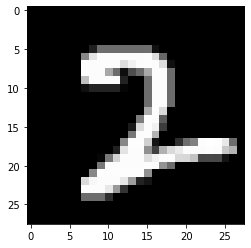

In [ ]:
for i, (image, label) in enumerate(trainloader):
    print('image shape:', image.shape)
    print('label shape:', label.shape)
    
    index = 0
    plt.imshow(image[index].reshape(28, 28), 'gray')
    print('Sample label:', label[index])
    break

## Trainer 정의

구현의 편의성을 위해 `Trainer`를 클래스로 만들어, 내부에 학습을 위한 `train`과 `test` 함수를 만드려고 합니다.     
학습과 평가 두가지를 위해 모델, 데이터셋, 옵티마이저, 손실 함수 모두를 argument로 받으려고 합니다.

In [ ]:
class Trainer():
    def __init__(self, trainloader, testloader, model, optimizer, criterion):
        """
        trainloader: train data's loader
        testloader: test data's loader
        model: model to train
        optimizer: optimizer to update your model
        criterion: loss function
        """
        self.trainloader = trainloader
        self.testloader = testloader
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        
    def train(self, epoch):
        """
        epoch: number of times each training sample is used
        """
        self.model.train()
        for e in range(epoch):
            running_loss = 0.0  
            for i, (inputs, labels) in enumerate(self.trainloader, 0): 
                # use gpu
                inputs = inputs.cuda()
                labels = labels.cuda()
                
                # zero the parameter gradients
                self.optimizer.zero_grad()    
                #  Q1) waht if we dind't clear up the gradients?

                # forward + backward + optimize
                outputs = self.model(inputs) # get output after passing through the network
                
                loss = self.criterion(outputs, labels) # compute model's score using the loss function 
                
                loss.backward() # perform back-propagation from the loss
                self.optimizer.step() # perform gradient descent with given optimizer

                # print statistics
                running_loss += loss.item()
                if (i+1) % 500 == 0:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / 500))
                    running_loss = 0.0

        print('Finished Training')
        
    def test(self):
        self.model.eval() 
        # Q2) Why should we change the network into eval-mode?
        
        test_loss = 0
        correct = 0
        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda() 
            
            output = self.model(inputs) 
            
            pred = torch.max(output, dim=1)[1]
            correct += (pred == labels).sum().item()

            test_loss /= len(self.testloader.dataset)
            
        print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.
                format(correct, len(self.testloader.dataset),
                100.* correct / len(self.testloader.dataset)))
        
    def get_confusion(self):
        self.model.eval()
        
        confusion = torch.zeros(10,10)
        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            output = self.model(inputs)
            pred = torch.argmax(output, dim=1)
            
            for num in range(output.shape[0]):
                confusion[pred[num], labels[num]] += 1
        
        return confusion

## Model, Optimizer, Criterion 정의

In [ ]:
import torch.nn as nn #
import torch.nn.functional as F # various activation functions for model
import torch.optim as optim # various optimization functions for model

### (1) 2-Layer FC model + Sigmoid

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: sigmoid
- Optimizer: SGD
- Loss: Cross-Entropy

In [ ]:
class MNIST_Net(nn.Module): 
    def __init__(self):
        super(MNIST_Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28, 30)
        self.fc1 = nn.Linear(30, 10)
        # self.act = nn.Sigmoid()

    def forward(self, x):
        # x.view convert the shape of tensor, (Batch_size,28,28) --> (Batch_size,28*28)
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = F.sigmoid(x) # Activation function 
        x = self.fc1(x)  # 30 -> 10, logit for each class
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() # create the neural network instance and load to the cuda memory.
criterion = nn.CrossEntropyLoss() # Define Loss Function. We use Cross-Entropy loss.
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) # optimizer receives training parameters and learning rate.

trainer = Trainer(trainloader = trainloader,
                  testloader = testloader,
                  model = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

[1,   500] loss: 2.325
[1,  1000] loss: 2.299
[1,  1500] loss: 2.280
[2,   500] loss: 2.255
[2,  1000] loss: 2.239
[2,  1500] loss: 2.227
[3,   500] loss: 2.202
[3,  1000] loss: 2.186
[3,  1500] loss: 2.172
[4,   500] loss: 2.141
[4,  1000] loss: 2.124
[4,  1500] loss: 2.106
Finished Training


In [ ]:
trainer.test()


Test set:  Accuracy: 6174/10000 (62%)



/home/sangmin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


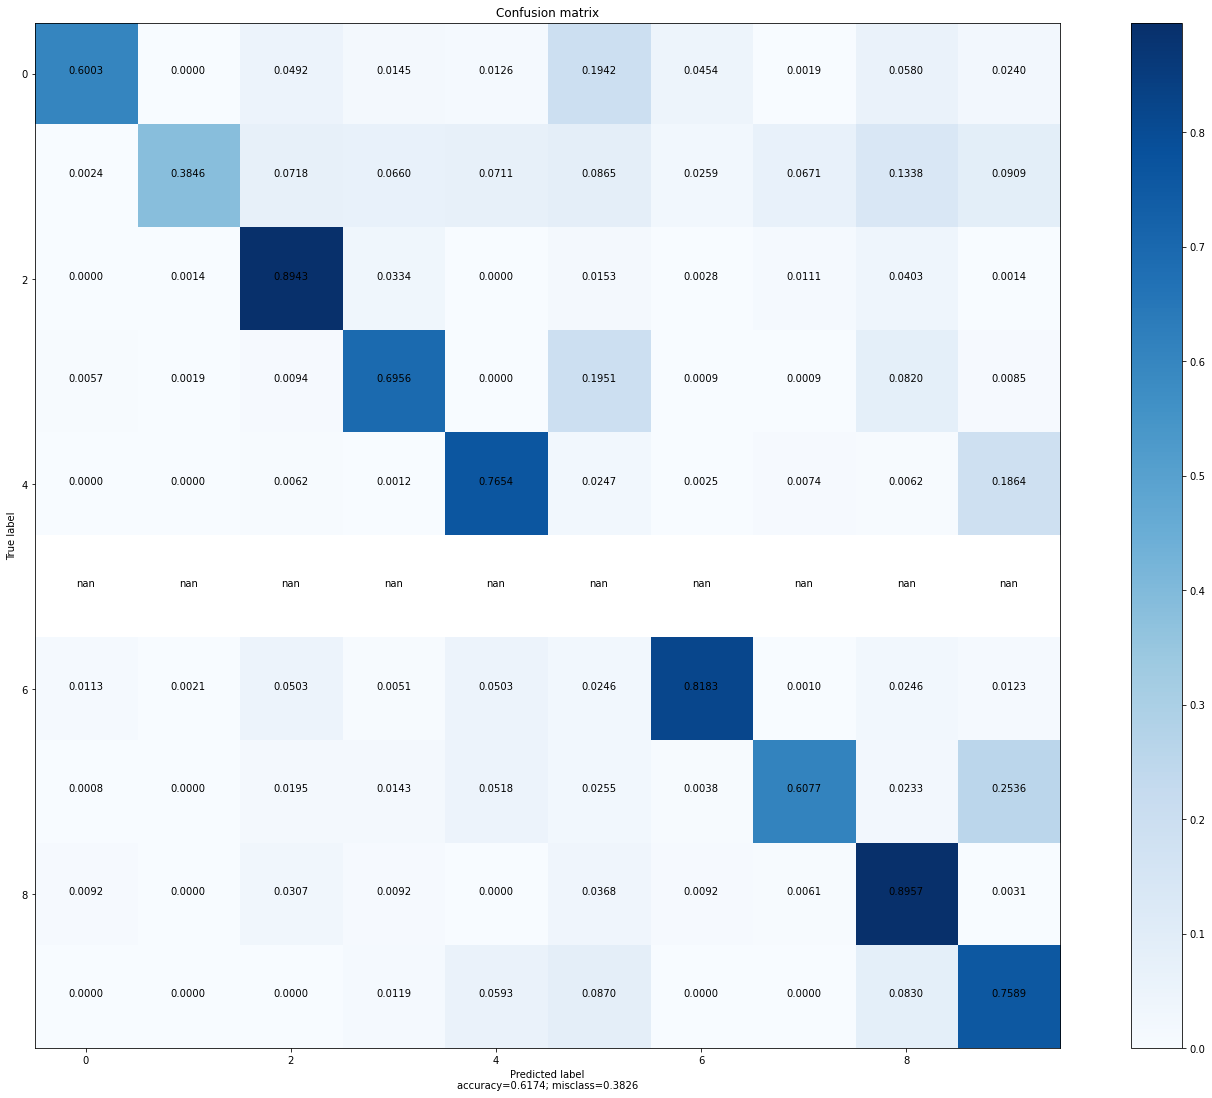

In [ ]:
plot_confusion_matrix(trainer.get_confusion().numpy())

### (2) 2-Layer FC model + ReLU

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: relu
- Optimizer: SGD
- Loss: Cross-Entropy

미분값이 계속해서 곱해지는 역전파 방식에서 Sigmoid 함수는 양끝에서 0 근처의 미분값을 뱉기 때문에, vanishing gradient 문제를 일으킬 가능성이 큽니다.    
따라서, 양수값에 대해서 1의 미분값을 뱉는 ReLU를 사용했을 때, 성능 향상을 기대해볼 수 있습니다.

![relu.png](https://cdn-images-1.medium.com/max/357/1*oePAhrm74RNnNEolprmTaQ.png)

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28, 30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = F.relu(x) # Activation function
        x = self.fc1(x)  # 30 -> 10
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)

trainer = Trainer(trainloader = trainloader,
                  testloader = testloader,
                  model = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

[1,   500] loss: 2.254
[1,  1000] loss: 2.152
[1,  1500] loss: 2.035
[2,   500] loss: 1.779
[2,  1000] loss: 1.619
[2,  1500] loss: 1.465
[3,   500] loss: 1.228
[3,  1000] loss: 1.111
[3,  1500] loss: 1.029
[4,   500] loss: 0.890
[4,  1000] loss: 0.839
[4,  1500] loss: 0.797
Finished Training


In [ ]:
trainer.test()


Test set:  Accuracy: 8408/10000 (84%)



### (3) 3-Layer FC model + ReLU

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- Optimizer: SGD
- Loss: Cross-Entropy

층이 깊어졌을 때 성능이 무조건 증가할지 살펴봅시다.

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) 

trainer = Trainer(trainloader = trainloader,
                  testloader = testloader,
                  model = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

[1,   500] loss: 2.301
[1,  1000] loss: 2.286
[1,  1500] loss: 2.268
[2,   500] loss: 2.225
[2,  1000] loss: 2.191
[2,  1500] loss: 2.145
[3,   500] loss: 2.034
[3,  1000] loss: 1.950
[3,  1500] loss: 1.846
[4,   500] loss: 1.635
[4,  1000] loss: 1.511
[4,  1500] loss: 1.375
Finished Training


In [ ]:
trainer.test()


Test set:  Accuracy: 7319/10000 (73%)



### (4) 2-Layer FC model + ReLU + Adam

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: relu
- Optimizer: Adam
- Loss: Cross-Entropy

이번엔 SGD가 아닌, 좀 더 최신의 Adam 옵티마이저를 사용해봅시다.

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = F.relu(x) 
        x = self.fc1(x) 
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

trainer = Trainer(trainloader = trainloader,
                  testloader = testloader,
                  model = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

[1,   500] loss: 0.681
[1,  1000] loss: 0.318
[1,  1500] loss: 0.272
[2,   500] loss: 0.222
[2,  1000] loss: 0.204
[2,  1500] loss: 0.205
[3,   500] loss: 0.173
[3,  1000] loss: 0.164
[3,  1500] loss: 0.159
[4,   500] loss: 0.142
[4,  1000] loss: 0.142
[4,  1500] loss: 0.136
Finished Training


In [ ]:
trainer.test()


Test set:  Accuracy: 9585/10000 (96%)



### (5) 2-Layer FC model + ReLU + Adam + Batch Normalization(BN)

- Input: (28 * 28)
- Hidden dimension: (30)
- Output dimension: 10
- activation: relu
- normalization: BN
- Optimizer: Adam
- Loss: Cross-Entropy

BN을 통해 각 배치 별로 평균과 분산을 이용해 정규화를 진행하는 것으로, covariate shift 문제를 해결해준다고 알려져 있습니다.

![BN.png](https://cerebras.net/wp-content/uploads/2021/03/1ETvcPhYH1lCfXndMiKW-jQ.png)

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28, 30)
        self.bn0 = nn.BatchNorm1d(30) # BatchNorm 
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = self.bn0(x)
        x = F.relu(x) 
        x = self.fc1(x)   
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

trainer = Trainer(trainloader = trainloader,
                  testloader = testloader,
                  model = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

[1,   500] loss: 0.717
[1,  1000] loss: 0.346
[1,  1500] loss: 0.275
[2,   500] loss: 0.216
[2,  1000] loss: 0.213
[2,  1500] loss: 0.194
[3,   500] loss: 0.172
[3,  1000] loss: 0.166
[3,  1500] loss: 0.163
[4,   500] loss: 0.145
[4,  1000] loss: 0.140
[4,  1500] loss: 0.152
Finished Training


In [ ]:
trainer.test()


Test set:  Accuracy: 9646/10000 (96%)



### `model.train()` 혹은 `model.eval()` 함수는 BN 층처럼 학습과 평가때 동작이 다르게되는 층을 위해서 사용하는 함수입니다.

아래 보시는 것처럼 BN을 사용함으로써 `running_mean`과 `running_var` 변수들이 생겼고, BN의 동작구조상 학습 때 구해진 평균과 분산을 평가때 사용되기 때문에 모델에게 학습 단계인지 아닌지를 알려주는 것입니다.

In [ ]:
mnist_net.state_dict().keys()

### Fully-connected 모델의 문제점은 파라미터의 수가 너무 많다는 것입니다.

파라미터의 수가 많으면 연산 속도나 GPU 메모리도 문제지만, 편향과 분산 오류 관점에서 오버피팅 문제를 야기할 수 있습니다.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(mnist_net)

23920

### (6) 2-Layer (Conv+FC) model + ReLU + Adam + BN

- Input: (28 * 28)
- Conv: 8 convolution filters with kernel_size=6 and stride=2 
- Hidden dimension (FC): 8 * 12 * 12
- Output dimension (FC): 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

Convolution layer를 통해 이미지의 공간적인 정보(Height, Width)를 고려해 연산을 했을 때, 이미지 분류 태스크의 성능이 어떻게 변화하는지 살펴봅시다.
![conv.png](https://miro.medium.com/max/2000/1*vkQ0hXDaQv57sALXAJquxA.jpeg)

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2) # Layer 1
        self.bn = nn.BatchNorm2d(8)  # 2d batch-norm is used in 3d inputs
        self.fc = nn.Linear(8*12*12, 10)   # Layer 2 

    def forward(self, x):
        x = self.conv0(x)
        x = self.bn(x)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

trainer = Trainer(trainloader = trainloader,
                  testloader = testloader,
                  model = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

[1,   500] loss: 0.390
[1,  1000] loss: 0.172
[1,  1500] loss: 0.125
[2,   500] loss: 0.087
[2,  1000] loss: 0.087
[2,  1500] loss: 0.080
[3,   500] loss: 0.065
[3,  1000] loss: 0.063
[3,  1500] loss: 0.060
[4,   500] loss: 0.048
[4,  1000] loss: 0.053
[4,  1500] loss: 0.060
Finished Training


In [ ]:
trainer.test()


Test set:  Accuracy: 9833/10000 (98%)



In [ ]:
count_parameters(mnist_net)

11842

### (7) 3-Layer (Conv+Pool+FC) model + ReLU + Adam + BN

- Input: (28 * 28)
- Conv: 8 convolution filters with kernel_size=6 and stride=2 
- Pool: AvgPool with kernel_size=2 and stride=2
- Hidden dimension (FC): 8 * 6 * 6
- Output dimension (FC): 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

AvgPool을 통해 FC layer에 들어가기 전 공간적인 정보를 유지한채 크기를 줄여보려 합니다.     
FC 층의 파라미터 수가 더 줄어들었을 때, 성능이 어떻게 변화할지 살펴봅시다.
![pool.png](https://blog.kakaocdn.net/dn/biczZ1/btqED1eyDLf/c5cBddY5vw8DRo0K0S49L1/img.png)

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2) # Layer 1
        self.bn = nn.BatchNorm2d(8)  
        self.pool = nn.AvgPool2d(2)
        self.fc = nn.Linear(8*6*6, 10) 

    def forward(self, x):
        x = self.conv0(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

trainer = Trainer(trainloader = trainloader,
                  testloader = testloader,
                  model = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

[1,   500] loss: 0.660
[1,  1000] loss: 0.250
[1,  1500] loss: 0.187
[2,   500] loss: 0.138
[2,  1000] loss: 0.118
[2,  1500] loss: 0.113
[3,   500] loss: 0.094
[3,  1000] loss: 0.083
[3,  1500] loss: 0.081
[4,   500] loss: 0.068
[4,  1000] loss: 0.070
[4,  1500] loss: 0.074
Finished Training


In [ ]:
trainer.test()


Test set:  Accuracy: 9815/10000 (98%)



In [ ]:
count_parameters(mnist_net)

3202